In [3]:
import os
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

import re
import pdb
import _pickle as cPickle
from collections import OrderedDict, defaultdict, Counter

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

from data_structure import Instance

# configure

In [4]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('output_path', 'data/synthetic/instances_ncrp.pkl', 'path of output data')

flags.DEFINE_integer('n_vocab', 900, 'size of vocab')
flags.DEFINE_integer('n_doc', 11000, 'num of doc')
flags.DEFINE_integer('doc_l', 100, 'size of vocab')

flags.DEFINE_string('f', '', 'kernel')

config = flags.FLAGS

# configure

In [5]:
def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth

In [6]:
tree_idxs = {0:[1, 2, 3], 
                      1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}
tree_depth = get_depth()
max_depth = max(get_depth().values())
child_to_parent_idxs = {child_idx: parent_idx for parent_idx, child_idxs in tree_idxs.items() for child_idx in child_idxs}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

bow_idxs = np.arange(config.n_vocab)

In [7]:
ones = np.ones(config.n_vocab//3)
zeros = np.zeros(config.n_vocab//3)
leaf_1 = np.concatenate([np.ones([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))])], 1).flatten()
leaf_2 = np.concatenate([np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.ones([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))])], 1).flatten()
leaf_3 = np.concatenate([np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.zeros([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))]), np.ones([int((config.n_vocab//9)**(1/2)), int((config.n_vocab//9)**(1/2))])], 1).flatten()
# leaf_1 = np.concatenate([np.ones(config.n_vocab//9), np.zeros(config.n_vocab//9), np.zeros(config.n_vocab//9)])
# leaf_2 = np.concatenate([np.zeros(config.n_vocab//9), np.ones(config.n_vocab//9), np.zeros(config.n_vocab//9)])
# leaf_3 = np.concatenate([np.zeros(config.n_vocab//9), np.zeros(config.n_vocab//9), np.ones(config.n_vocab//9)])

In [8]:
tree_topic_bow_raw = {
                0: np.ones(config.n_vocab, dtype=np.float32),
                1: np.concatenate([ones, zeros, zeros]).astype(np.float32),
                2: np.concatenate([zeros, ones, zeros]).astype(np.float32),
                3: np.concatenate([zeros, zeros, ones]).astype(np.float32),
                10: np.concatenate([leaf_1, zeros, zeros]).astype(np.float32),
                11: np.concatenate([leaf_2, zeros, zeros]).astype(np.float32),
                12: np.concatenate([leaf_3, zeros, zeros]).astype(np.float32),
                20: np.concatenate([zeros, leaf_1, zeros]).astype(np.float32),
                21: np.concatenate([zeros, leaf_2, zeros]).astype(np.float32),
                22: np.concatenate([zeros, leaf_3, zeros]).astype(np.float32),
                30: np.concatenate([zeros, zeros, leaf_1]).astype(np.float32),
                31: np.concatenate([zeros, zeros, leaf_2]).astype(np.float32),
                32: np.concatenate([zeros, zeros, leaf_3]).astype(np.float32),
}

tree_topic_bow = {topic_idx: topic_bow_raw/np.sum(topic_bow_raw) for topic_idx, topic_bow_raw in tree_topic_bow_raw.items()}
topic_bow = np.concatenate([tree_topic_bow[topic_idx][None, :] for topic_idx in topic_idxs], 0)

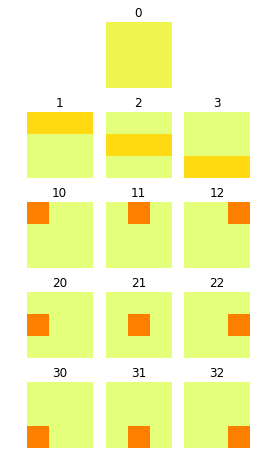

In [74]:
from matplotlib.colors import Normalize # Normalizeをimport

plt.figure(figsize=(4, 8))
plt.subplot(5,3,2)
plt.title(topic_idxs[0])
plt.axis('off')
plt.imshow(topic_bow[0].reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(topic_bow)))

for i in range(1, len(topic_idxs)):
    plt.subplot(5,3,i+3)
    plt.title(topic_idxs[i])
    plt.axis('off')
    plt.imshow(topic_bow[i].reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=np.max(topic_bow)))

# sample

In [33]:
def nCRP(tree_sticks_topic):
    tree_prob_topic = {}
    tree_prob_leaf = {}
    # calculate topic probability and save
    tree_prob_topic[0] = 1.
    
    for parent_idx, child_idxs in tree_idxs.items():
        rest_prob_topic = tree_prob_topic[parent_idx]        
        for child_idx in child_idxs:
            stick_topic = tree_sticks_topic[child_idx]
            if child_idx == child_idxs[-1]:
                prob_topic = rest_prob_topic * 1.
            else:
                prob_topic = rest_prob_topic * stick_topic
            
            if not child_idx in tree_idxs: # leaf childs
                tree_prob_leaf[child_idx] = prob_topic
            else:
                tree_prob_topic[child_idx] = prob_topic
                
            rest_prob_topic -= prob_topic
            
    return tree_prob_leaf

def sbp(max_depth, gam):
    prob_depth = []
    rest_prob_topic = 1.
    for depth in range(max_depth):
        stick_topic = np.random.beta(1, gam, 1)[0]
        if depth == max_depth -1:
            prob_topic = rest_prob_topic * 1.
        else:
            prob_topic = rest_prob_topic * stick_topic
        prob_depth.append(prob_topic)
        rest_prob_topic -= prob_topic
    
    prob_depth = np.array(prob_depth, dtype=np.float32)
    return prob_depth

def get_ancestor_idxs(leaf_idx, ancestor_idxs = None):
    if ancestor_idxs is None: ancestor_idxs = [leaf_idx]
    
    parent_idx = child_to_parent_idxs[leaf_idx]
    ancestor_idxs += [parent_idx]
    if parent_idx in child_to_parent_idxs: get_ancestor_idxs(parent_idx, ancestor_idxs)
    return ancestor_idxs[::-1]

def get_prob_topic(tree_prob_leaf, prob_depth):
    tree_prob_topic = defaultdict(float)
    
    leaf_ancestor_idxs = {leaf_idx: get_ancestor_idxs(leaf_idx) for leaf_idx in tree_prob_leaf}
    for leaf_idx, ancestor_idxs in leaf_ancestor_idxs.items():
        prob_leaf = tree_prob_leaf[leaf_idx]
        for i, ancestor_idx in enumerate(ancestor_idxs):
            prob_ancestor = prob_leaf * prob_depth[i]
            tree_prob_topic[ancestor_idx] += prob_ancestor
    return tree_prob_topic

In [56]:
alp = 2.
lam = 1.
gam = 2.

In [57]:
prob_topics = []
for idx_doc in range(config.n_doc):
    if idx_doc%1000 == 0: print(idx_doc)
    instance = Instance()
    instance.idx = idx_doc
    
    tree_sticks_topic = {}
    for topic_idx in topic_idxs:
        depth = tree_depth[topic_idx]
        tree_sticks_topic[topic_idx] = np.random.beta(1, alp*(lam**depth), 1)
        
    tree_prob_leaf = nCRP(tree_sticks_topic)
#     prob_depth = np.random.dirichlet(np.ones(max_depth, dtype=np.float32) * gam)
    prob_depth = sbp(max_depth, gam)
    
    tree_prob_topic = get_prob_topic(tree_prob_leaf, prob_depth)            
    prob_topic = np.concatenate([tree_prob_topic[topic_idx] for topic_idx in topic_idxs])
    
    prob_topics.append(prob_topic)
    
prob_topic_mean = np.mean(prob_topics, 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [58]:
prob_topic_mean

array([0.33250571, 0.07380521, 0.04949263, 0.0986836 , 0.04887881,
       0.03370354, 0.06713179, 0.03320136, 0.02199226, 0.0437395 ,
       0.06588319, 0.04404064, 0.08694175])

In [59]:
instances = []

for idx_doc in range(config.n_doc):
    if idx_doc%1000 == 0: print(idx_doc)
    instance = Instance()
    instance.idx = idx_doc
    
    tree_sticks_topic = {}
    for topic_idx in topic_idxs:
        depth = tree_depth[topic_idx]
        tree_sticks_topic[topic_idx] = np.random.beta(1, alp*(lam**depth), 1)
        
    tree_prob_leaf = nCRP(tree_sticks_topic)
    prob_depth = sbp(max_depth, gam)
#     prob_depth = np.random.dirichlet(np.ones(max_depth, dtype=np.float32) * gam)
    
    tree_prob_topic = get_prob_topic(tree_prob_leaf, prob_depth)            
    prob_topic = np.concatenate([tree_prob_topic[topic_idx] for topic_idx in topic_idxs])
    
    prob_bow = prob_topic.dot(topic_bow)
    prob_bow /= np.sum(prob_bow)
    
    token_idxs = np.random.choice(config.n_vocab, config.doc_l, p=prob_bow)
    bow = np.array([Counter(token_idxs)[bow_idx] for bow_idx in bow_idxs])
    assert len(bow) == config.n_vocab
    instance.bow = bow
    
    instances.append(instance)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [60]:
np.sum(prob_topic_mean[10:13])

0.19686558482981398

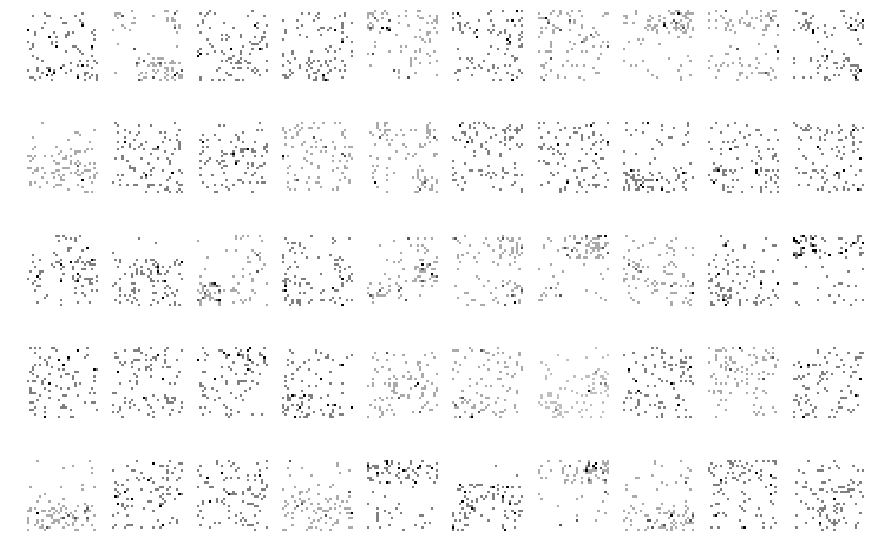

In [61]:
plt.figure(figsize=(15, 10))
for i, instance in enumerate(instances[:50]):
    plt.subplot(5,10,i+1)
    plt.axis('off')
    plt.imshow(instance.bow.reshape(int(config.n_vocab**(1/2)),int(config.n_vocab**(1/2))), cmap='gray_r')

# write out

In [62]:
instances_train = instances[:10000]
instances_valid = instances[10000:]
instances_test = instances_valid

In [63]:
idx_to_word = {bow_idx: str(10*(bow_idx//3+1) + bow_idx%3) for bow_idx in bow_idxs}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}

In [64]:
print('saving preprocessed instances...')
cPickle.dump((instances_train, instances_valid, instances_test, word_to_idx, idx_to_word, bow_idxs),open(config.output_path,'wb'))

saving preprocessed instances...
